# Convolutions based FE loss function implementation

## 1. Introduction

In this workbook, we cover the usage of DiffNets to solve Poisson's Equation. The Poisson equation for the scalar field $u({\bf x})$ can be written as

$$
\begin{align}
-\nabla \cdot (\nu({\bf x}) \nabla u({\bf x})) &= 0 \ \textrm{ in } D\\
u &= 0 \ \textrm{ on } \partial D
\end{align}
$$

where, the domain $D = [0,1]^2$ is the unit square; ${\bf x} = (x,y)$ represents the independent variables and $\nu({\bf x})$ represents the *diffusivity* (or *permeability*) of the medium. In this example, $\nu = \nu({\bf x}, \omega)$ where $\omega$ is a parameter that can be randomly chosen from a parameter space $\Omega$. Thus, by varying $\omega$, we can obtain different $\nu$ fields, each of which then renders a different solution to the above Poisson's equation. This means, every time a different $\omega$ is chosen, the solution needs to be obtained by solving the equation. But using DiffNet, we can train a model offline one time and learn the correct mapping so that we do not need to solve the equation again as long as $\omega$ is chosen from the same parameter space $\Omega$. Therefore, we wish to train a DiffNet $G_{nn}$ such that it is able to construct the correct mapping between the input space of $S^d$ and the space of the solutions $U^d$.

For the purpose of this tutorial, it suffices to assume that the logarithm of $\nu({\bf x}; \omega)$ can be expressed in summation form as follows:
$$
\begin{align}
\ln(\nu({\bf x}; \omega)) &= \sum_{i=1}^{m}\omega_i \xi_i(x)\eta_i(y)\\
\text{or},\  \nu({\bf x}; \omega) &= \exp \Big(\sum_{i=1}^{m}\omega_i \xi_i(x)\eta_i(y)\Big)
\end{align}
$$
where $\xi$ and $\eta$ are known functions of $x$ and $y$ respectively. See Sec. 2.2.1 of [this paper](https://arxiv.org/abs/2104.14538) for more details. We choose $m=6$ for this example and assume that each $\omega_i$ is chosen from $[-3,3]$ interval randomly. Thus, $\omega\in\Omega = [-3,3]^6$.

## 2. DiffNet
A trained DiffNet can take a full field of diffusivity (or forcing) and map it to the full field solution. For example, in the below schematic, we see a trained DiffNet $G_{nn}$ takes a matrix $S^d$ (numerical version of $\nu({\bf x})$) as input and map it to another matrix $U^d$ (approximated version of $u({\bf x}))$:
![](https://raw.githubusercontent.com/rocketmlhq/sciml/main/05_DiffNets/xdiffnet-scheme.png)
Both $S^d$ and $U^d$ are matrices (or images) of the same size ($6\times 6$ or, $5\times 5$ "finite elements"). The neural network $G_{nn}$ can be thought of as a having a UNet architecture as below:
![](https://raw.githubusercontent.com/rocketmlhq/sciml/main/05_DiffNets/UNetArch.png)

Suppose the network parameters are given by $\theta$. Then, given such discretized representations of $S^d$ and $U^d$, DiffNet solves the Poisson's equation by minimizing the integral loss function given by:
$$
J(\theta) = \frac{1}{N_s}\sum_{j=1}^{N_s} \int \nu_j({\bf x}; \omega)|\nabla u_j({\bf x}, \theta)|^2 d{\bf x},
$$
where $u_j = G_{nn}(\nu_j, \theta)$, i.e., the solution corresponding to the $j^{th}$ sample of diffusivity.

The solution is then given by:
$$
\begin{align}
\theta^* &= \arg\min J(\theta),\\
u &= G_{nn}(\nu, \theta^*).
\end{align}
$$

We minimize the loss function $J(\theta)$ using Adam optimizer.

The DiffNet library provides in-built capability to approximate full field solutions and Lagrangian basis functions as convolution kernels along with evaluations on Gauss quadrature points. To use these features for solving the Poisson's equation, we need to implement two classes:
1. A dataset class `KLSum` (derived from `torch.utils.Dataset`): to implement the diffusivity, forcing and the boundary conditions.
2. An equation class `Poisson` (derived from `DiffNet.DiffNetFEM`): to implement the loss function, training step, optimizer configuration, query step etc.

## 3. Imports
We begin with few imports

In [1]:
import os
import sys
import json
import torch
import numpy as np

import matplotlib
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    # 'font.family': 'serif',
    'font.size':12,
})
from matplotlib import pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
seed_everything(42)

import DiffNet
from DiffNet.networks.wgan_old import GoodGenerator
from DiffNet.networks.autoencoders import AE
from DiffNet.DiffNetFEM import DiffNet2DFEM
from DiffNet.datasets.parametric.klsum import KLSumStochastic
from DiffNet.datasets.single_instances.klsum import Dataset

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

Global seed set to 42


## 4. Dataset class
Suppose we discretize the 2D domain into regularly spaced $N\times N$ grid points (i.e., $(N-1)\times(N-1)$ finite elements.

The `KLSum` class holds the given "input data" of the equation, i.e., the diffusivity ($\nu$) and the boundary conditions ($u_{\partial D}$). The important thing to note here is that, since DiffNet is based on full-field calculations, all three of these data need to be stored in tensor format. Specifically, since the current equation is defined on a 2D square domain, we store each of $\nu$, $f$ and $u_{\partial D}$ in 2D matrices of size $N\times N$.

In [2]:
from tqdm import tqdm
from torch.utils import data
from DiffNet.gen_input_calc import generate_diffusivity_tensor


class KLSum(data.Dataset):
    'PyTorch dataset for sampling coefficients'
    def __init__(self, domain_size=64, kl_terms=6, filename='', coeff_array=[]):
        """
        Initialization
        """
        if filename != '':
            self.coeffs = np.load(filename)
        else:
            if coeff_array != []:
                self.coeffs = coeff_array
            else:
                raise ValueError("Either filename or an array must be provided")
        self.domain_size = domain_size
        self.kl_terms = kl_terms
        self.dataset = []
        
        print('loading dataset')
        for coeff in tqdm(self.coeffs[:100]):
            domain = generate_diffusivity_tensor(coeff, output_size=self.domain_size, n_sum_nu=kl_terms).squeeze()
            # bc1 will be source, u will be set to 1 at these locations
            bc1 = np.zeros_like(domain)
            bc1[:,0] = 1

            # bc2 will be sink, u will be set to 0 at these locations
            bc2 = np.zeros_like(domain)
            bc2[:,-1] = 1

            self.dataset.append(np.array([domain,bc1,bc2]))
        self.dataset = np.array(self.dataset)
        self.n_samples = self.dataset.shape[0]

    def __len__(self):
        'Denotes the total number of samples'
        return self.n_samples

    def __getitem__(self, index):
        'Generates one sample of data'
        inputs = self.dataset[index]
        forcing = np.zeros_like(self.dataset[index][0])
        return torch.FloatTensor(inputs), torch.FloatTensor(forcing).unsqueeze(0)



## 5. Training data
As discussed above, the formula for calculating $\nu$ for a particular $\omega$ is known to us. So, to create the training dataset of multiple $\nu$, we essentially need to create a training dataset of multiple $\omega$ chosen from the 6-dimensional space $\Omega$ and thereafter calculate $\nu$ at each of those $\omega$. Before defining the 

In [3]:
!wget https://github.com/rocketmlhq/sciml/raw/main/05_DiffNets/sobol_6d.npy

--2021-11-15 03:59:35--  https://github.com/rocketmlhq/sciml/raw/main/05_DiffNets/sobol_6d.npy
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rocketmlhq/sciml/main/05_DiffNets/sobol_6d.npy [following]
--2021-11-15 03:59:35--  https://raw.githubusercontent.com/rocketmlhq/sciml/main/05_DiffNets/sobol_6d.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3145856 (3.0M) [application/octet-stream]
Saving to: ‘sobol_6d.npy’

sobol_6d.npy        100%[===================>]   3.00M  --.-KB/s    in 0.1s    

2021-11-15 03:59:36 (25.3 MB/s) - ‘sobol_6d.npy’ saved [3145856/3145856]



## 6. Equation class

Now we need to define the equation class `Poisson` that inherits the `DiffNet.DiffNetFEM` class which in turn inherits the `LightningModule` class from `pytorch_lightning.core`. The main purpose of `Poisson` is to implement the training step and the loss function along with optimizer configurations (if necessary). Let us discuss them one by one:
* `training_step`: this function will be called by `PytorchLightning` every training step with an input `batch`. This `batch` represents the data for a minibatch and is obtained by `PytorchLightning` by calling the `__getitem__` function in the `DataRectangle` class.
* `loss(u, I, f)`: the loss function can be implemented in many ways, but essentially takes the data of the equation and calculates the loss value. In this implementation `loss` takes the currently predicted field `u` and the other inputs (BC, nu, f). Inside this function, we evaluate the integral $J(u) = \frac{1}{N_s}\sum_{i=1}^{N_s} \int \nu_i|\nabla u_i|^2 d{\bf x}$. This is an important step and is done as follows:
    * Extract `nu` and `bc` from `imputs_tensor`
    * Apply the boundary conditions on `u` using the boundary masks (i.e., `bc1` and `bc2` that contain zeros in the interior points, and ones on the boundary points.
    * Now we need to evaluate the values in the integrand at the Gauss quadrature points. Given any field `g` on the grid points, we can evaluate `g` on **_all_** the Gauss quadrature points in $D$, by calling `g_GP = self.gauss_pt_evaluation(g)`. The derivatives of `g` can be evaluated on the Gauss points directly by `g_x_GP = self.gauss_pt_evaluation_der_x(g)` and `g_y_GP = self.gauss_pt_evaluation_der_y(g)` for the $x$ and $y$ derivative respectively.
    * Once all the integration values are evaluated on the quadrature points, the next step is to simply write down the integration using the quadrature data, exactly as it appears in the loss formula.
* Along with the above two functions, some other auxiliary functions can be added to this class as needed, e.g., `do_query`, `plot_contours`, `on_epoch_end` etc.
* `on_epoch_end` is called by `PytorchLightning` at the end of each epoch during training. We can plot the current `u` vlaue at the end of each epoch by implementing this function accordingly.

In [4]:
class Poisson(DiffNet2DFEM):
    """docstring for Poisson"""
    def __init__(self, network, dataset, **kwargs):
        super(Poisson, self).__init__(network, dataset, **kwargs)

    def loss(self, u, inputs_tensor, forcing_tensor):

        f = forcing_tensor # renaming variable
        
        # extract diffusivity and boundary conditions here
        nu = inputs_tensor[:,0:1,:,:]
        bc1 = inputs_tensor[:,1:2,:,:]
        bc2 = inputs_tensor[:,2:3,:,:]

        # apply boundary conditions
        u = torch.where(bc1>0.5,1.0+u*0.0,u)
        u = torch.where(bc2>0.5,u*0.0,u)


        nu_gp = self.gauss_pt_evaluation(nu)
        f_gp = self.gauss_pt_evaluation(f)
        u_gp = self.gauss_pt_evaluation(u)
        u_x_gp = self.gauss_pt_evaluation_der_x(u)
        u_y_gp = self.gauss_pt_evaluation_der_y(u)

        transformation_jacobian = self.gpw.unsqueeze(-1).unsqueeze(-1).unsqueeze(0).type_as(nu_gp)
        res_elmwise = transformation_jacobian * (nu_gp * (u_x_gp**2 + u_y_gp**2) - (u_gp * f_gp))
        res_elmwise = torch.sum(res_elmwise, 1) 

        # transformation_jacobian = (0.5 * self.h)**2 * self.gpw.unsqueeze(-1).unsqueeze(-1).unsqueeze(0).type_as(nu_gp)
        # res_elmwise = 0.5 * transformation_jacobian * (nu_gp * (u_x_gp**2 + u_y_gp**2) - (u_gp * f_gp))
        # res_elmwise = torch.sum(res_elmwise, 1) 

        loss = torch.mean(res_elmwise)
        return loss

    def forward(self, batch):
        inputs_tensor, forcing_tensor = batch
        u = self.network(inputs_tensor[:,0:1,:,:])
        return u, inputs_tensor, forcing_tensor

    def training_step(self, batch, batch_idx):
        u, inputs_tensor, forcing_tensor = self.forward(batch)
        loss_val = self.loss(u, inputs_tensor, forcing_tensor).mean()
        return {"loss": loss_val}

    def training_step_end(self, training_step_outputs):
        loss = training_step_outputs["loss"]
        self.log('PDE_loss', loss.item())
        self.log('loss', loss.item())
        return training_step_outputs

    def configure_optimizers(self):
        lr = self.learning_rate
        # opts = [torch.optim.LBFGS(self.network.parameters(), lr=lr, max_iter=5)]
        opts = [torch.optim.Adam(self.network.parameters(), lr=lr)]
        # schd = []
        schd = [torch.optim.lr_scheduler.MultiStepLR(opts[0], milestones=[10,15,30], gamma=0.1)]
        return opts, schd
    
    def do_query(self, inputs, forcing):
        u, inputs_tensor, forcing_tensor = self.forward((inputs.type_as(next(self.network.parameters())), 
                                                         forcing.type_as(next(self.network.parameters()))))
        
        f = forcing_tensor.squeeze().detach().cpu() # renaming variable
        
        # extract diffusivity and boundary conditions here
        nu = inputs_tensor[:,0:1,:,:]
        bc1 = inputs_tensor[:,1:2,:,:]
        bc2 = inputs_tensor[:,2:3,:,:]        
        # process diffusivity
        k = nu.squeeze().detach().cpu()

        # apply boundary conditions
        u = u[:,0:1,:,:]
        u = torch.where(bc1>0.5,1.0+u*0.0,u)
        u = torch.where(bc2>0.5,u*0.0,u)
        u = u.squeeze().detach().cpu()
        
        return u, k, f
    
    def plot_contours(self,k,u):
        num_sample = k.shape[0]
        plt_num_row = k.shape[0]
        plt_num_col = 2
        fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(4*plt_num_col,2*plt_num_row),
                            subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
        for ax_row in axs:
            for ax in ax_row:
                ax.set_xticks([])
                ax.set_yticks([])              
        
        # print(np.linalg.norm(diff.flatten())/self.domain_size)
#         im = axs[0].imshow(k,cmap='jet')
#         fig.colorbar(im, ax=axs[1]); axs[1].set_title(r'$\nu$')
#         im = axs[1].imshow(u,cmap='jet', vmin=0.0, vmax=1.0)
#         fig.colorbar(im, ax=axs[2]); axs[2].set_title(r'$u_{\theta}$')
#         plt.show()
        
        for idx in range(num_sample):
            im0 = axs[idx][0].imshow(k[idx,:,:],cmap='jet')
            fig.colorbar(im0, ax=axs[idx,0]); axs[idx,0].set_title(r'$\nu$')
            im1 = axs[idx][1].imshow(u[idx,:,:],cmap='jet')
            fig.colorbar(im1, ax=axs[idx,1]); axs[idx,1].set_title(r'$u_{\theta}$')  
    
    def on_epoch_end(self):
        num_query = 6
        plt_num_row = num_query
        plt_num_col = 2
        fig, axs = plt.subplots(plt_num_row, plt_num_col, figsize=(2*plt_num_col,1.2*plt_num_row),
                            subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
        for ax_row in axs:
            for ax in ax_row:
                ax.set_xticks([])
                ax.set_yticks([])
        
        self.network.eval()
        inputs, forcing = self.dataset[0:num_query]
        forcing = forcing.repeat(num_query,1,1,1)

        ub, inputs_tensor, forcing_tensor = self.forward((inputs.type_as(next(self.network.parameters())), forcing.type_as(next(self.network.parameters()))))
        
        loss = self.loss(ub, inputs_tensor, forcing_tensor[:,0:1,:,:])

        for idx in range(num_query):
            f = forcing_tensor # renaming variable
            
            # extract diffusivity and boundary conditions here
            nu = inputs_tensor[idx,0:1,:,:]
            u = ub[idx,0:1,:,:]
            bc1 = inputs_tensor[idx,1:2,:,:]
            bc2 = inputs_tensor[idx,2:3,:,:]

            # apply boundary conditions
            u = torch.where(bc1>0.5,1.0+u*0.0,u)
            u = torch.where(bc2>0.5,u*0.0,u)

            k = nu.squeeze().detach().cpu()
            u = u.squeeze().detach().cpu()

            im0 = axs[idx][0].imshow(k,cmap='jet')
            fig.colorbar(im0, ax=axs[idx,0])
            im1 = axs[idx][1].imshow(u,cmap='jet')
            fig.colorbar(im1, ax=axs[idx,1])  
        plt.savefig(os.path.join(self.logger[0].log_dir, 'contour_' + str(self.current_epoch) + '.png'))
        self.logger[0].experiment.add_figure('Contour Plots', fig, self.current_epoch)
        plt.close('all')


## 7. MLflow for experiment tracking and model deployment

MLflow is an open source platform for managing the end-to-end machine learning lifecycle. It tackles four primary functions:

- Tracking experiments to record and compare parameters and results (MLflow Tracking).
- Managing and deploying models from a variety of ML libraries to a variety of model serving and inference platforms (MLflow Models).
- Providing a central model store to collaboratively manage the full lifecycle of an MLflow Model, including model versioning, stage transitions, and annotations (MLflow Model Registry).

More information [here](https://www.mlflow.org/docs/latest/index.html#)



![image.png](https://www.mlflow.org/docs/latest/_images/scenario_4.png)

- localhost maps to the server on which the current notebook is running

- Tracking server maps to the server at environment variable `TRACKING_URL` that can be printed using `os.environ.get("TRACKING_URL")`

- Create an mlflow client that communicates with the tracking server

In [5]:
import mlflow
from mlflow import pyfunc

# Setting a tracking uri to log the mlflow logs in a particular location tracked by 
from mlflow.tracking import MlflowClient
tracking_uri = os.environ.get("TRACKING_URL")
client = MlflowClient(tracking_uri=tracking_uri)
mlflow.set_tracking_uri(tracking_uri)

## Create an experiment in mlflow database using mlflow client

- Get the list of all the experiments (Click on **Experiments** tab on the sidebar to see the list)
- Create a new experiment named *numpy_deployment* if it doesn't exist
- Set *numpy_deployment* as the new experiment under which different **runs** are tracked

## MLflow Entity Hierarchy

- Experiment 1
    - Run 1
        - Parameters
        - Metrics
        - Artifacts
            - Folder 1
                - File 1
                - File 2
            - Folder 2 
    - Run 2
    - Run 3

- Experiment 2
- Experiment 3        

In [6]:
# Setting a tracking project experiment name to keep the experiments organized
experiments = client.list_experiments()
experiment_names = []
for exp in experiments:
    experiment_names.append(exp.name)
experiment_name = "diffnet_deployment"
if experiment_name not in experiment_names:
    mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)


## Python Class for inference

- ModelWrapper is derived from mlflow.pyfunc.PythonModel [more info](https://www.mlflow.org/docs/latest/python_api/mlflow.pyfunc.html)
- load_context() member function is used to load the model. In this case, it loads a keras trained model which can be loaded.
- predict member function takes a numpy array as input and outputs another numpy array
- An object of this class will be saved as a pickle file in blob storage

In [69]:
## Model Wrapper that takes 
class ModelWrapper(mlflow.pyfunc.PythonModel):
    def load_context(self,context):
        import numpy as np
        import torch
        import os
        model = torch.load(os.path.join(context.artifacts["model_path"], 'network.pt'))
        self.model = model
        print("Model initialized")
    
    def predict(self, context, model_input):
        import numpy as np
        import json
        import torch
        print(model_input.values.shape)
        inputs = np.array(model_input.values.tolist())
        print(inputs.shape)
        if len(inputs.shape) == 4:
            print('batch inference')
            predictions = self.model(torch.from_numpy(inputs).float()).detach().cpu().numpy().tolist()
        elif len(inputs.shape) == 3:
            print('single inference')
            inputs = inputs.unsqueeze(0)
            predictions = self.model(torch.from_numpy(inputs).float()).detach().cpu().numpy().tolist()
        elif len(inputs.shape) == 2:
            print('single inference squeeze')
            inputs = inputs.unsqueeze(0).unsqueeze(0)
            predictions = self.model(torch.from_numpy(inputs).float()).detach().cpu().numpy().tolist()            
        else:
            raise ValueError('invalid input shape')
        return json.dumps(predictions)

## 7. Initializations

In [42]:
kl_terms = 6
domain_size = 32
LR = 1e-3
batch_size = 128
sample_size = 65536
sobol_file = 'sobol_'+str(kl_terms)+'d.npy'
max_epochs = 1
print("Max_epochs = ", max_epochs)

dataset = KLSum(domain_size=domain_size, kl_terms=kl_terms, filename=sobol_file)
network = AE(in_channels=1, out_channels=1, dims=16, n_downsample=2)
basecase = Poisson(network, dataset, batch_size=batch_size, domain_size=domain_size, learning_rate=LR)

# ------------------------
# 1 INIT TRAINER
# ------------------------
logger = pl.loggers.TensorBoardLogger('.', name="klsum_"+str(domain_size))
csv_logger = pl.loggers.CSVLogger(logger.save_dir, name=logger.name, version=logger.version)

checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(monitor='loss',
    dirpath=logger.log_dir, filename='{epoch}-{step}',
    mode='min', save_last=True)

trainer = Trainer(callbacks=[checkpoint],
    checkpoint_callback=True, logger=[logger,csv_logger],
    max_epochs=max_epochs, deterministic=True, profiler='simple')

Max_epochs =  1
loading dataset


100%|██████████| 100/100 [00:00<00:00, 1342.00it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


## 8. Training

In [43]:
trainer.fit(basecase)


  | Name      | Type          | Params
--------------------------------------------
0 | network   | AE            | 264 K 
1 | N_gp      | ParameterList | 16    
2 | dN_x_gp   | ParameterList | 16    
3 | dN_y_gp   | ParameterList | 16    
4 | d2N_x_gp  | ParameterList | 16    
5 | d2N_y_gp  | ParameterList | 16    
6 | d2N_xy_gp | ParameterList | 16    
--------------------------------------------
264 K     Trainable params
96        Non-trainable params
264 K     Total params
1.058     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  13.179         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  7.694          	|1              	|  7.694          	|  58.379         	|
run_training_batch                 	|  5.815          	|1              	|  5.815          	|  44.122         	|
optimizer_step_with_closure_0      	|  5.8141         	|1              	|  5.8141         	|  44.115         	|
training_step_and_backward         	|  5.5151         	|1              	|  5.5151         	|  41.846         	|
backward                           

## Register a model using mlflow

- Log user-defined parameters in a remote database through a remote server
- Create a model_wrapper object using ModelWrapper() class in the above cell
- Create a default conda environment that need to be installed on the Docker conatiner that serves a REST API
- Save the model object as a pickle file and conda environment as artifacts (files) in S3 or Blob Storage

In [70]:
torch.save(basecase.network, os.path.join(logger.log_dir, 'network.pt'))
# instantiate the python inference model wrapper for the server
model_wrapper = ModelWrapper()


# checkpointing and logging the model in mlflow
artifact_path = logger.log_dir
model_artifacts = {"model_path" : artifact_path}

#Conda environment
env = mlflow.pytorch.get_default_conda_env()

## Utility function to add libraries to conda environment
def add_libraries_to_conda_env(_conda_env,libraries=[],conda_dependencies=[]):
    dependencies = _conda_env["dependencies"]
    dependencies = dependencies + conda_dependencies
    pip_index = None
    for _index,_element in enumerate(dependencies):
        if type(_element) == dict:
            if "pip" in _element.keys():
                pip_index = _index
                break
    dependencies[pip_index]["pip"] =  dependencies[pip_index]["pip"] + libraries
    _conda_env["dependencies"] = dependencies
    return _conda_env
env = add_libraries_to_conda_env(env,libraries=['git+https://github.com/adityabalu/DiffNet.git'])
with mlflow.start_run():
    mlflow.pyfunc.log_model("diffnet_model", python_model=model_wrapper, artifacts=model_artifacts, conda_env=env)

## 9. Query

loading dataset


100%|██████████| 5/5 [00:00<00:00, 1134.70it/s]


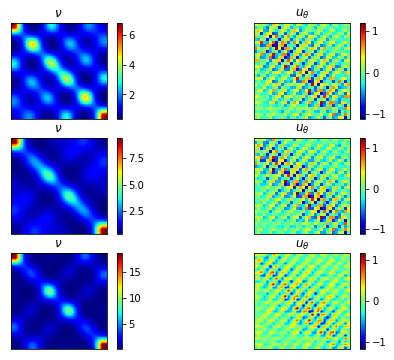

In [90]:
import requests
import json

query_array = np.random.rand(5,6) # five samples of size 6
dataset = KLSum(domain_size=domain_size, kl_terms=kl_terms, filename='', coeff_array=query_array)

inputs, forcing = dataset[0:3]
nu = inputs[:,0:1,:,:].numpy()
import pandas as pd
################################################################################
# *** SET MODEL URL HERE BEFORE RUNNING THIS CELL (instructions above) ***
# Example: https://<random_string>.sciml.rocketml.net/invocations
url = ""
################################################################################

u_list = []
for idx in range(nu.shape[0]):
    json_data = pd.DataFrame(nu[idx:idx+1,...].tolist(), columns=['image']).to_json(orient='split')

    if not url:
        raise ValueError('Model URL not set! Please read instructions on how to deploy model, set the correct URL, and try again.')

    headers = {"Content-Type":"application/json; format=pandas-split"}

    if url:
        response = requests.post(url,data=json_data,headers=headers)
        if response.status_code == 200:
            u = np.array(json.loads(response.json())).astype(np.float32)
            u_list.append(u)
        else:
            print(response.status_code)
            print("REST API deployment is in progress -- please try again in a few minutes!")
    else:
        print("Make sure that the model is in ON state. Copy the Endpoint")

u = np.array(u_list)

# plot
basecase.plot_contours(nu.squeeze(),u.squeeze())